PREDICTING HOUSE PRICES

1. Clean your data
    - Remove outliers
    - Drop unnecessary columns: those with more than half null values
    - Check for leakage, high cardinality and multicollinearity
2. Slplit your data
    - Feature matrix: X_train
    - Target vector: y_train
3. Dumb model
    - Create a baseline model (using mean)
    - Find `mean_absolute_error` for the baseline model
4. Automation `make_pipeline`
    - Encode categorical variable `OneHotEncoder`
    - Impute missing values `SimpleImputer`
    - Build your model `LinearRegression` or `Ridge`
    - Fit your model to training data
5. Evaluation
    - Use your model to make predictions `model.predict(X_train)`
    - Calculate the training mean_absolute_error
    - Compare with baseline mean_absolute_error
6. Test
    - Test your model with new data: does it generalize? Does it beat the baseline?
7. Communicate results
    - Make a function
    - Create an interactive dashboard

In [1]:
# imports
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
# Create a function to automate the cleaning process
def dataWrangle(filePath):
    """Function takes file path and returns a dataframe
    Args
    -----
    filePath: csv
    
    Return: DataFrame"""
    # Read in file
    df = pd.read_csv(filePath)

    # Format the data
        # Extract states
    df["state"] = df["place_with_parent_names"].str.split("|", expand=True)[2]
    df["neighborhood"] = (df["place_with_parent_names"]
                   .str.split("|", expand=True)[3])
        # Extract coordinates
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True)
        # Recast the type of some columns
    df[["lat", "lon"]] = df[["lat", "lon"]].astype(float)

    # Drop columns
    df.drop(columns=["place_with_parent_names", "lat-lon"], inplace=True)

    # Subset data: apartments, only in Capital Federal, less than $400_000
    df = df[df["state"] == "Capital Federal"]
    df = df[df["property_type"] == "apartment"]
    df = df[df["price_aprox_usd"] < 400_000]

    # Remove outlier: surface_covered_in_m2 btwn 0.1 and 0.9 inclusive
    lower, upper = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    df = df[df["surface_covered_in_m2"]
    .apply(lambda x: True if lower <=x<= upper else False)]

    # Remove extra colums
    df.drop(columns="state", inplace=True)

    # Drop columns with more than 1/2 null values
    for column in df.columns:
        if (df[column].isnull().sum()) > (len(df[column]) / 2):
            df.drop(columns=column, inplace=True)

    # Drop high and low cardinality features
    for col in df.columns:
        if df[col].nunique() < 3 or df[col].nunique() == len(df[col]):
            df.drop(columns=col, inplace=True)

    # Drop leaky columns
    leaks = ["price", "price_aprox_local_currency",
             "price_per_m2", "price_usd_per_m2"]
    df.drop(columns=leaks, inplace=True)

    # Drop highly correlated columns
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

In [3]:
data = glob("data/arg[0-9].csv")
len(data)

5

In [4]:
df_ls = [dataWrangle(datum) for datum in data]
df = pd.concat(df_ls, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   neighborhood           6582 non-null   object 
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


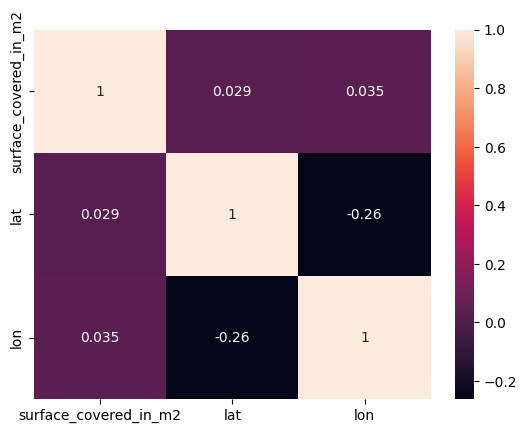

In [5]:
# Check for multicollinearity --> Heat maps
corr = (df.select_dtypes(include="number")
        .loc[:, df.select_dtypes(include="number")
        .columns != "price_aprox_usd"]).corr()
sns.heatmap(corr, annot=True);

In [6]:
# Split
target = "price_aprox_usd"
X_train = df.loc[:, df.columns != target]
y_train = df[target]

In [7]:
# Baseline
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)
round(mae_baseline, 2)

44860.11

In [8]:
# Automation
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                      SimpleImputer(), Ridge())
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [9]:
# Evaluating
y_pred_train = model.predict(X_train)
mae_training = mean_absolute_error(y_pred_train, y_train)
round(mae_training, 2)

24207.11

In [10]:
# Test your model with new data

In [11]:
# Communicate the results: functions n intercative dashboards
    # Function
def prediction(area, lat, lon, neighborhood):
    """Takes input values and returns predictions"""
    df = pd.DataFrame({
        "surface_covered_in_m2": area,
        "neighborhood": neighborhood,
        "lat": lat,
        "lon": lon,
    }, index=[0])
    predictn = model.predict(df)

    return f"Price of an apartment USD {predictn}"

In [12]:
prediction(39, -34.553897, -58.451939, "Belgrano")

'Price of an apartment USD [130491.9044703]'

In [21]:
    # Interactive dashboard

# Neighborhood data
neighborhoods = X_train['neighborhood'].unique()

def update_lat_lon_range(change):
        """Update the min and max values of the lat and lon sliders
        based on the selected neighborhood. User can only select lat
        and lon values within the chosen neighborhood"""
        selected_neighborhood = change.new  # get the new value
        lat_slider.min = X_train[X_train['neighborhood'] == selected_neighborhood]['lat'].min()
        lat_slider.max = X_train[X_train['neighborhood'] == selected_neighborhood]['lat'].max()
        lon_slider.min = X_train[X_train['neighborhood'] == selected_neighborhood]['lon'].min()
        lon_slider.max = X_train[X_train['neighborhood'] == selected_neighborhood]['lon'].max()


neighborhood_dropdown = Dropdown(options=neighborhoods, value=neighborhoods[0], description='Select Neighborhood:')
lat_slider = FloatSlider(value=X_train[X_train['neighborhood'] == neighborhoods[0]]['lat'].mean(), step=0.1, description='Select Latitude:')
lon_slider = FloatSlider(value=X_train[X_train['neighborhood'] == neighborhoods[0]]['lon'].mean(), step=0.1, description='Select Longitude:')

# Observe changes in the selected neighborhood and update lat and lon sliders accordingly
neighborhood_dropdown.observe(update_lat_lon_range, names='value')


interact(
    prediction,
    area=IntSlider(
        value=X_train['surface_covered_in_m2'].mean(),
        min=X_train['surface_covered_in_m2'].min(),
        max=X_train['surface_covered_in_m2'].max(),
        step=1,
        description='Select Area:',
        readout_format='d'
    ),
    lat=lat_slider,
    lon=lon_slider,
    neighborhood=neighborhood_dropdown
);


interactive(children=(IntSlider(value=53, description='Select Area:', max=101, min=30), FloatSlider(value=0.0,…